In [1]:
import glob
import ast
import time
import numpy as np
import pandas as pd
from tqdm import tqdm 
import cv2
import json
import collections
from PIL import Image
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import zipfile

from tqdm import tqdm
import shutil

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading package

In [3]:
import sys
from pathlib import Path

here_path = Path().resolve()
repo_path = here_path.parents[1]
sys.path.append(str(repo_path))

In [4]:
from py.utils import verifyDir,verifyFile, verifyDataFrame

In [5]:
from py.config import Config

cfg = Config()

np.random.seed(cfg.RANDOM_STATE)
cfg.DATA_PATH, cfg.MODEL_PATH

('/media/felipe/DATA19/datasets/', '/media/felipe/DATA19/models/')

In [6]:
QSCORE_PATH=f"{cfg.DATA_PATH}pp2/{cfg.SCORING_METHOD}/{cfg.PLACE_LEVEL}/"
IMAGES_PATH = f"{cfg.DATA_PATH}pp2/images/"

FEATURES_PATH = f"{cfg.DATA_PATH}pp2/segmentations/{cfg.DATASET_SEG_NAME}/{cfg.MODEL_SEG_NAME}/"
MODEL_PATH = f"{cfg.MODEL_PATH}pp2/{cfg.ML_TYPE}/{cfg.SCORING_METHOD}/"

### Loading Data and Models

In [7]:
features_df = pd.read_csv(f"{FEATURES_PATH}segmentations.csv", sep=";", low_memory=False)
features_df = features_df.loc[:, (features_df != 0).any(axis=0)].copy()
feature_names = features_df.columns.tolist()
feature_names.remove("image_id")
features_df

,wall,building,sky,floor,tree,ceiling,road,windowpane,grass,sidewalk,...,tank,trade_name,pot,bicycle,sculpture,traffic_light,ashcan,pier,flag,image_id
0,0.000000,1.574167,42.730833,0.0,5.031667,0.0,36.835833,0.0,0.033333,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d677cfdc9f035870040af
1,0.232500,5.849167,8.832500,0.0,37.846667,0.0,31.366667,0.0,7.345000,3.849167,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6c8ffdc9f03587004fcc
2,0.125833,21.213333,13.651667,0.0,15.863333,0.0,25.864167,0.0,0.789167,11.385833,...,0.0,0.0,1.377500,0.0,0.0,0.0,0.000,0.0,0.0,513d6b38fdc9f03587004c82
3,0.000000,0.015833,41.790833,0.0,16.505833,0.0,32.465000,0.0,0.000000,3.591667,...,0.0,0.0,0.193333,0.0,0.0,0.0,0.205,0.0,0.0,513d6bb6fdc9f03587004db0
4,0.199167,0.106667,6.445000,0.0,46.457500,0.0,13.627500,0.0,18.599167,9.519167,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d67a8fdc9f03587004125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,0.000000,12.243333,37.321667,0.0,5.678333,0.0,31.678333,0.0,0.000000,0.475000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6ba6fdc9f03587004d8e
1297,0.000000,38.336667,19.234167,0.0,0.928333,0.0,38.718333,0.0,1.423333,1.359167,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d686ffdc9f03587004385
1298,0.000000,44.598333,15.456667,0.0,1.174167,0.0,23.995000,0.0,0.000000,7.303333,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6a2afdc9f0358700499f
1299,17.496667,0.057500,38.990833,0.0,7.129167,0.0,34.227500,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,513d6845fdc9f035870042f7


In [8]:
%%time
data_df = pd.read_csv(f"{QSCORE_PATH}scores.csv", sep=";", low_memory=False)
data_df["image_path"] = f"{IMAGES_PATH}" + data_df["image_path"]
data_df.sort_values(by=[cfg.PERCEPTION_METRIC], ascending=False, inplace=True)
data_df = pd.merge(data_df, features_df, how="inner", on=["image_id"])
data_df

CPU times: user 163 ms, sys: 41 ms, total: 204 ms
Wall time: 204 ms


,image_id,lat,long,city,country,continent,safety,beautiful,wealthy,lively,...,minibike,tank,trade_name,pot,bicycle,sculpture,traffic_light,ashcan,pier,flag
0,513d677cfdc9f035870040af,42.370774,-71.126977,Boston,USA,North America,8.583389,5.333333,6.055556,5.029020,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1,513d6c8ffdc9f03587004fcc,42.385246,-71.173652,Boston,USA,North America,8.222581,6.075926,5.277778,5.432792,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
2,513d6b38fdc9f03587004c82,42.353972,-71.063971,Boston,USA,North America,8.016417,7.222222,7.500000,3.333333,...,0.0,0.0,0.0,1.377500,0.0,0.0,0.0,0.000,0.0,0.0
3,513d6bb6fdc9f03587004db0,42.315775,-71.034048,Boston,USA,North America,7.945597,5.303030,3.888889,7.810280,...,0.0,0.0,0.0,0.193333,0.0,0.0,0.0,0.205,0.0,0.0
4,513d67a8fdc9f03587004125,42.301764,-71.114991,Boston,USA,North America,7.918534,5.277778,6.333333,3.948302,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,513d6ba6fdc9f03587004d8e,42.412917,-71.106858,Boston,USA,North America,1.764706,3.845679,2.777778,3.918651,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1297,513d6a2afdc9f0358700499f,42.374378,-71.119751,Boston,USA,North America,1.666667,5.611111,6.833333,6.494829,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1298,513d686ffdc9f03587004385,42.384908,-70.982451,Boston,USA,North America,1.666667,3.333333,1.666667,3.522727,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0
1299,513d6845fdc9f035870042f7,42.312479,-71.052465,Boston,USA,North America,1.615313,2.148148,2.962963,3.802910,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0


In [9]:
%%time
from py.models.datasets import PlacePulse

pp = PlacePulse(data_df)
pp.DataPreparation(delta=cfg.DELTA, emotion=cfg.PERCEPTION_METRIC)
pp.TaskPreparation(task_type=cfg.ML_TASK)
pp.DataSplit()

print(f"Train samples: {len(pp.train_df)}")
print(f"Test samples: {len(pp.test_df)}")

Applying delta 0.42.
Top max: 8.583389450056117, min:5.280795156526829, size: 546
Bot max: 4.855792355792356, min:0.8333333333333334, size: 546
Train samples: 819
Test samples: 273
CPU times: user 614 ms, sys: 81.8 ms, total: 695 ms
Wall time: 696 ms


In [10]:
train_df = pp.train_df
test_df = pp.test_df

### Loading model

In [11]:
model_grid = joblib.load(f'{MODEL_PATH}{cfg.DATASET_SEG_NAME}_{cfg.MODEL_SEG_NAME}_model_search.pkl')
model_grid.get_best_model()

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma=0.01, max_iter=1000,
                     probability=True, random_state=42))])

### Training

In [12]:
X_train = np.array(pp.train_df[feature_names].values.tolist())
X_test = np.array(pp.test_df[feature_names].values.tolist())
y_train = np.array(pp.train_df["target"].tolist())
y_test = np.array(pp.test_df["target"].tolist())
X_train.shape, X_test.shape

((819, 65), (273, 65))

In [13]:
len(feature_names), X_train.shape, X_test.shape

(65, (819, 65), (273, 65))

In [14]:
label_map = dict( zip( train_df['target'], train_df['label'] ) )
label_map

{0: 'not safety', 1: 'safety'}

In [15]:
class_map = dict( zip( train_df['label'], train_df['target'] ) )
class_map

{'not safety': 0, 'safety': 1}

# SHAP(SHapley Additive exPlanations) Explanations

The SHAP value for feature \( i \) is defined as:

$
\phi_i(f, x) =
\sum_{S \subseteq F \setminus \{i\}}
\frac{|S|! (|F| - |S| - 1)!}{|F|!}
\left[
f_{S \cup \{i\}}(x_{S \cup \{i\}})
-
f_S(x_S)
\right]
$

- $F$ = set of all features  
- $S \subseteq F \setminus \{i\}$ = subset of features excluding feature $i$  
- $|S|$ = size of subset $S$  
- $|F|$ = total number of features  
- $f_S(x_S)$ = model trained or evaluated using only features in subset $S$  
- $\phi_i$ = contribution of feature $i$

- **The combinatorial weight**

  $\frac{|S|! (|F| - |S| - 1)!}{|F|!}$

  ensures fair averaging across all possible feature orderings.

- **Additive Explanation Model**
  SHAP explanations follow an additive form:
  
  $g(z') = \phi_0 + \sum_{i=1}^{M} \phi_i z'_i$ $\text{ and }$ $\sum_{i=1}^{M} \phi_i = f(x) - \mathbb{E}[f(x)]$
  
  Where:
    
    - $\phi_0 = \mathbb{E}[f(x)]$ (expected model output / baseline)
    - $\phi_i$ = SHAP value of feature $i$  
    - $z'_i \in \{0,1\}$ indicates presence of feature $i$  
    - $M$ = total number of features

- **Interpretation**
  SHAP computes the average marginal contribution of a feature across all possible subsets of features:

    $\phi_i = \mathbb{E}_S \left[ f_{S \cup \{i\}}(x_{S \cup \{i\}}) - f_S(x_S) \right]$

    This ensures:
    
    - Fair attribution
    - Consistency
    - Additivity
    - Local accuracy

In [16]:
from py.models.explainers import SHAPAnalyzer

analyzer = SHAPAnalyzer(model=model_grid.get_best_model(),
                        model_name=model_grid.get_best_model_name(),
                        ml_type=cfg.ML_TYPE,
                        feature_names=feature_names,
                        class_names=list(class_map.keys())
                    )

In [17]:
analyzer.fit(X_train)

[SHAPAnalyzer] 'svm' → KERNELExplainer


In [18]:
samples_to_test = X_test[:10]

In [19]:
contributions = analyzer.shap_values(samples_to_test)
contributions

  0%|          | 0/10 [00:00<?, ?it/s]

.values =
array([[[ 0.        ,  0.        ],
        [ 0.00379781, -0.00379781],
        [ 0.        ,  0.        ],
        ...,
        [-0.00242169,  0.00242169],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [-0.04008602,  0.04008602],
        ...,
        [-0.00252508,  0.00252508],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.02189938, -0.02189938],
        ...,
        [ 0.00832318, -0.00832318],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-0.00194211,  0.00194211],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.     

In [20]:
shap_df = analyzer.get_shap_df(contributions)
shap_df

,wall,building,sky,floor,tree,ceiling,road,windowpane,grass,sidewalk,...,minibike,tank,trade_name,pot,bicycle,sculpture,traffic_light,ashcan,pier,flag
0,0.0,-0.003798,0.000000,0.0,-0.031035,0.0,-0.010850,0.0,0.000000,0.003462,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.002422,0.0,0.0
1,0.0,0.000000,0.040086,0.0,0.003689,0.0,0.000000,0.0,0.000000,0.005892,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.002525,0.0,0.0
2,0.0,0.000000,-0.021899,0.0,-0.024028,0.0,-0.015577,0.0,0.000000,-0.011563,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.008323,0.0,0.0
3,0.0,0.000000,0.043934,0.0,0.037728,0.0,0.011898,0.0,0.000000,0.013730,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.005046,0.0,0.0
4,0.0,0.002890,0.052190,0.0,0.047698,0.0,0.000000,0.0,0.004718,0.000000,...,0.000916,0.0,0.0,0.0,0.0,0.0,0.0,0.001618,0.0,0.0
5,0.0,0.000000,-0.032426,0.0,-0.020066,0.0,-0.001940,0.0,-0.001990,-0.003348,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.002052,0.007180,0.0,0.016913,0.0,0.000000,0.0,0.000000,-0.006220,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.0,0.019432,0.0,-0.013739,0.0,0.004686,-0.004454,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001942,0.0,0.0
8,0.0,0.000000,-0.013283,0.0,-0.019944,0.0,-0.005739,0.0,-0.001888,-0.000685,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,-0.002353,-0.009900,0.0,-0.029533,0.0,-0.016033,0.0,-0.002154,-0.008590,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [21]:
features_df = analyzer.get_feature_importance(contributions)
features_df

,feature,mean_abs_shap
0,tree,0.025007
1,sky,0.022090
2,rock,0.016624
3,plant,0.009605
4,road,0.007578
...,...,...
60,bridge,0.000000
61,hill,0.000000
62,bench,0.000000
63,palm,0.000000


In [22]:
analyzer.top_features(contributions, top_n_features=cfg.TOP_K_FEATURES)


Top 15 features by mean |SHAP|:
  feature  mean_abs_shap
     tree       0.025007
      sky       0.022090
     rock       0.016624
    plant       0.009605
     road       0.007578
 sidewalk       0.005794
    truck       0.003531
signboard       0.003252
    fence       0.003187
      car       0.002693
   ashcan       0.002188
    earth       0.002151
    grass       0.001544
 building       0.001109
   stairs       0.000480


,feature,mean_abs_shap
0,tree,0.025007
1,sky,0.022090
2,rock,0.016624
3,plant,0.009605
4,road,0.007578
5,sidewalk,0.005794
6,truck,0.003531
7,signboard,0.003252
8,fence,0.003187
9,car,0.002693


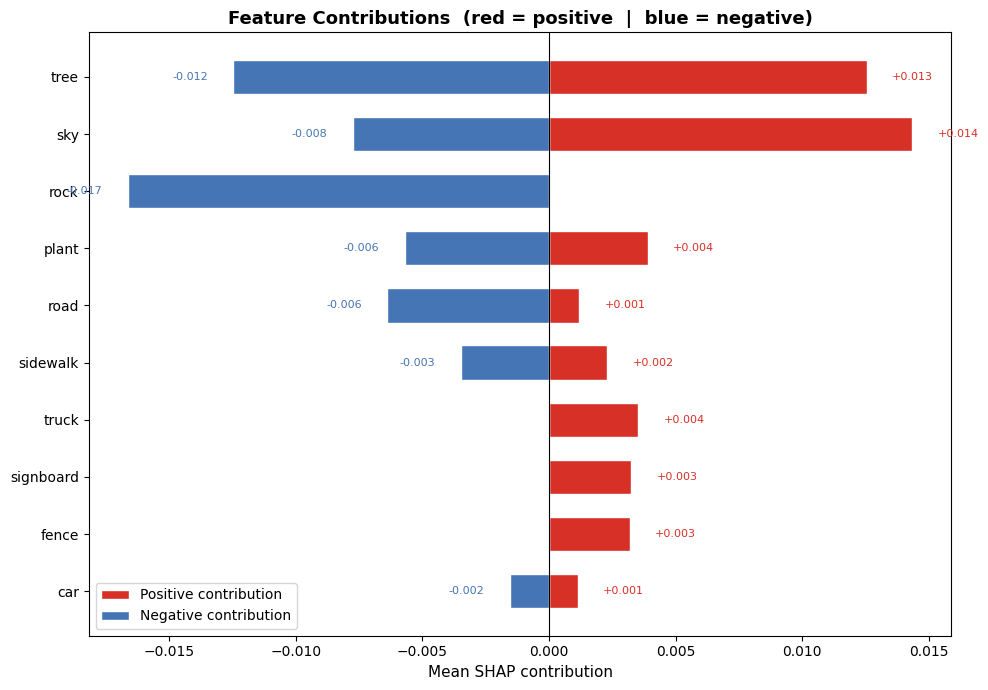

In [23]:
analyzer.contribution_plot(contributions)

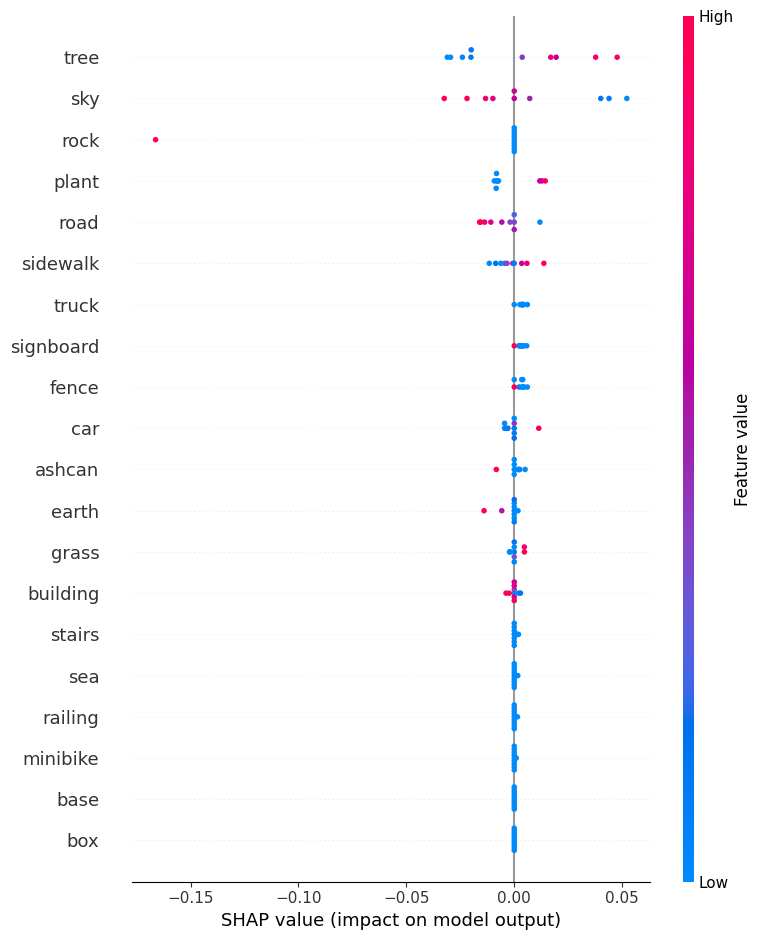

In [24]:
analyzer.summary_plot(samples_to_test, contributions)

As this feature's value increases, how does its impact on the prediction change — and does that relationship depend on another feature?

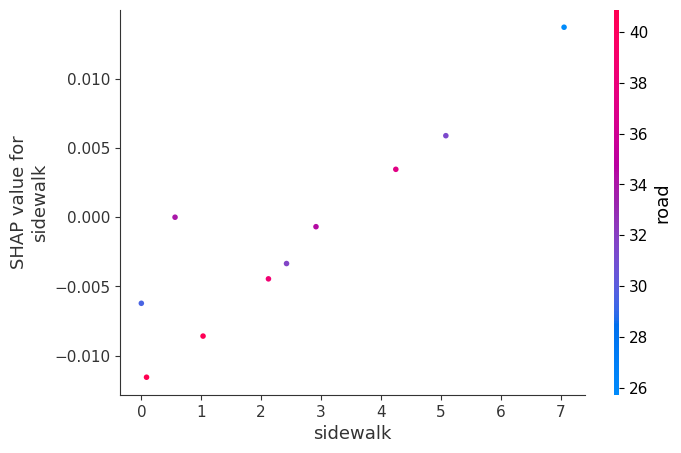

In [25]:
analyzer.dependence_plot("sidewalk", samples_to_test, contributions, interaction_feature="road")

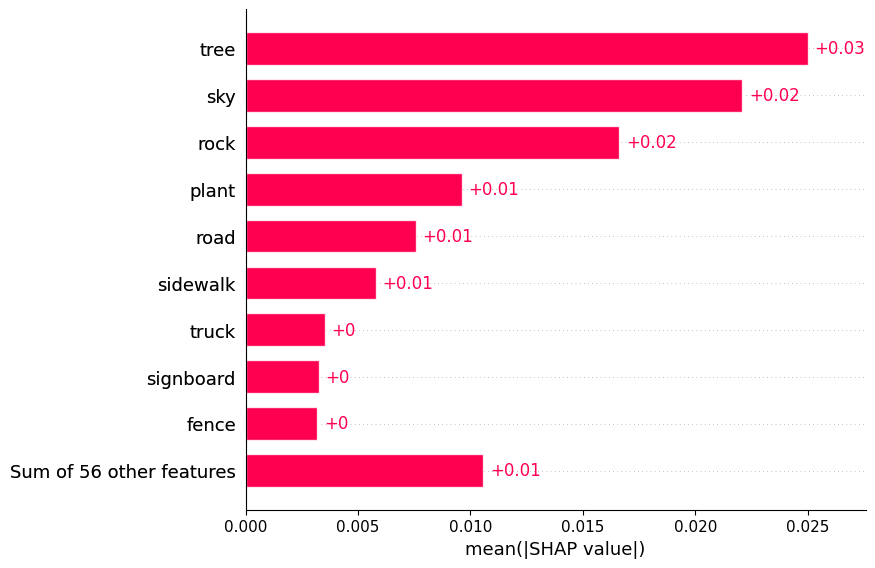

In [26]:
analyzer.bar_plot(contributions)

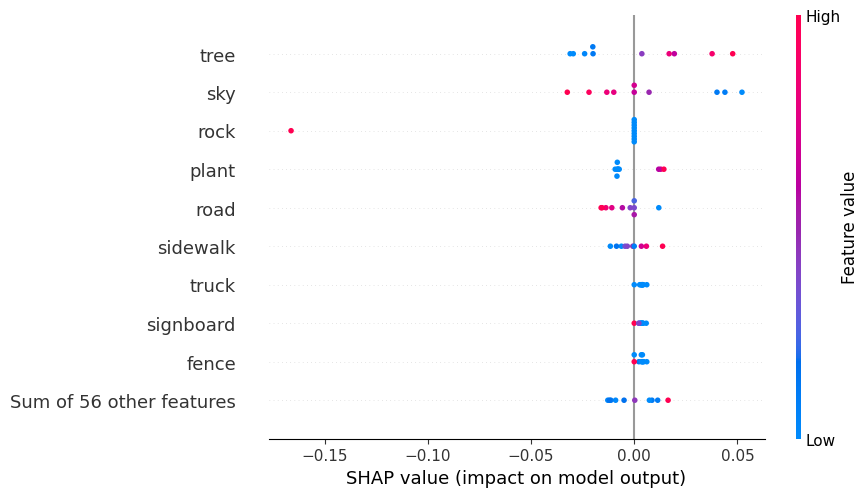

In [27]:
analyzer.beeswarm_plot(contributions)

  0%|          | 0/1 [00:00<?, ?it/s]

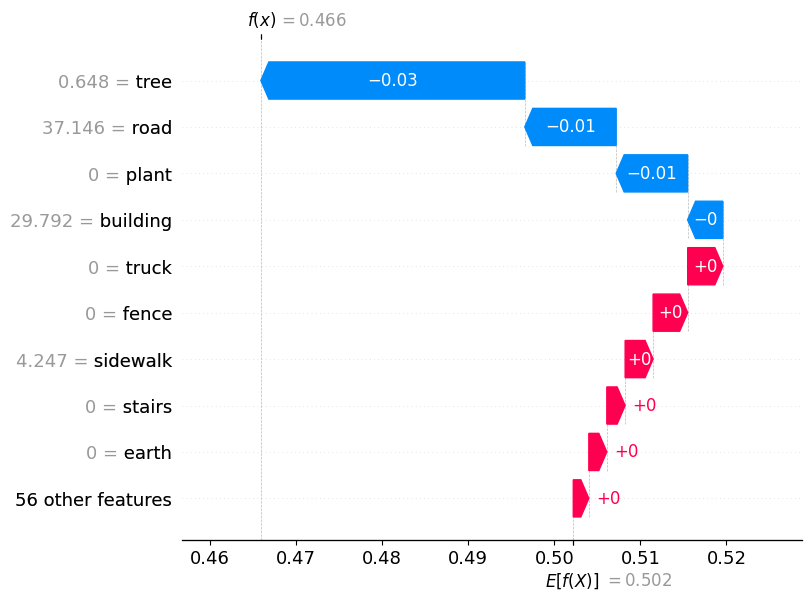

In [28]:
analyzer.waterfall_plot(samples_to_test, sample_idx=0)


Top 15 features by mean |SHAP|:
  feature  mean_abs_shap
     tree       0.025007
      sky       0.022090
     rock       0.016624
    plant       0.009605
     road       0.007578
 sidewalk       0.005794
    truck       0.003531
signboard       0.003252
    fence       0.003187
      car       0.002693
   ashcan       0.002188
    earth       0.002151
    grass       0.001544
 building       0.001109
   stairs       0.000480


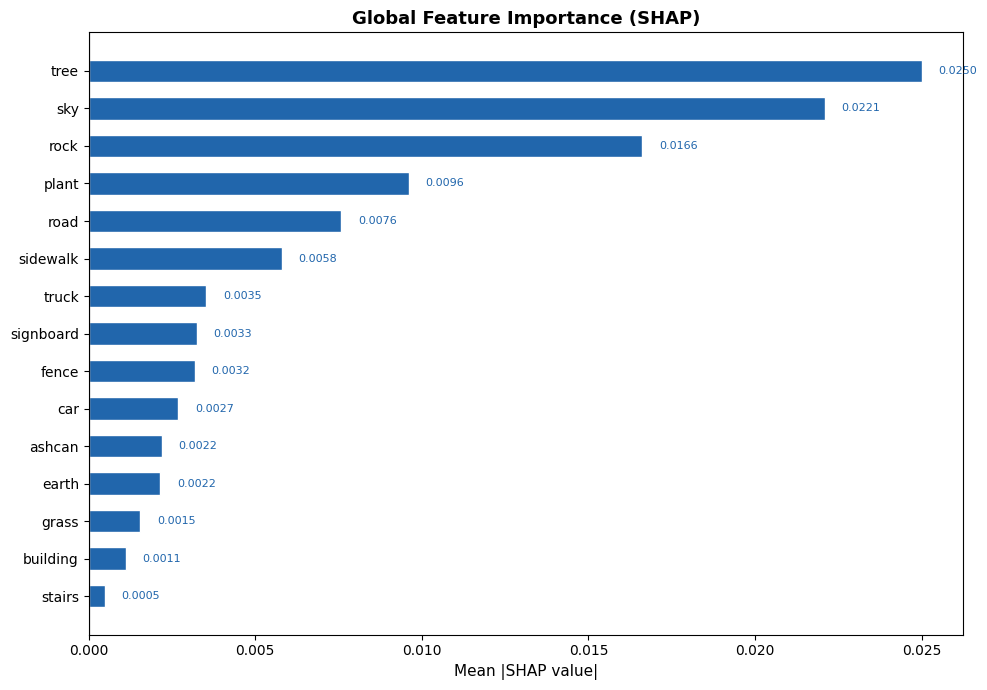

In [29]:
analyzer.feature_importance_plot(contributions, top_n_features=cfg.TOP_K_FEATURES)